In [1]:
import polars as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
from matplotlib.rcsetup import cycler

#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False


colors = ['#a1c9f4', '#8de5a1', '#ff9f9b', '#d0bbff', '#fffea3', '#b9f2f0']
cmap = mpl.colors.ListedColormap(colors)
bar1 = {'color': colors[0], 'edgecolor': 'k'}
bar2 = {'color': colors[1], 'edgecolor': 'k'}
bar3 = {'color': colors[2], 'edgecolor': 'k'}

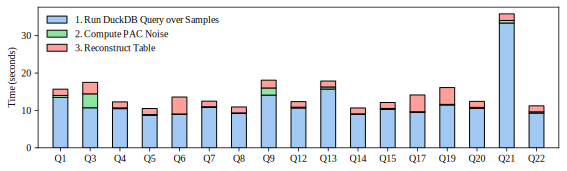

In [93]:
# Load JSON file into Polars DataFrame

df = pl.read_json("benchmarks/merged.json")

# Get the 'query' column as list of labels
queries = df["query"].to_list()

# Get the step columns
step_columns = [col for col in df.columns if col.startswith("step")]

# Get values for each step column
step_values = [df[col].to_list() for col in step_columns]

# Bar positions
x = range(len(queries))

# Create the stacked bar plot
plt.figure(figsize=(8, 2.5))
bottom = [0] * len(queries)
bar_width = 0.5
step_columns = ["1. Run DuckDB Query over Samples", "2. Compute PAC Noise", "3. Reconstruct Table"]
for values, label, style in zip(step_values, step_columns, [bar1, bar2, bar3]):
    plt.bar(x, values, bottom=bottom, label=label, width=bar_width, **style)
    bottom = [b + v for b, v in zip(bottom, values)]

# Final plot formatting
plt.xlim([x[0] - (1.5*bar_width), x[-1] + (1.5*bar_width)])
plt.xticks(x, queries, ha='center')

plt.ylabel('Time (seconds)')

plt.legend()
plt.tight_layout()
plt.show()


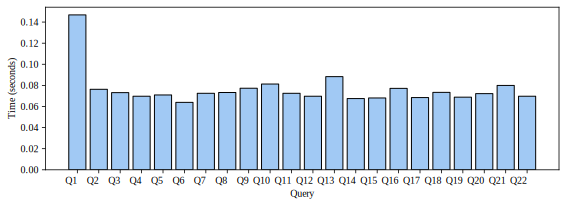

In [3]:
unnoised = pl.read_json("unnoised/times.json")
# Get the 'query' column as list of labels
queries_unnoised = unnoised["query"].to_list()
# Just has a 'total' column for times
unnoised_total = unnoised["total"].to_list()
x = range(len(queries_unnoised))
# Create the bar plot for unnoised times
plt.figure(figsize=(8, 3))
plt.bar(x, unnoised_total, color=colors[0], edgecolor='k')
plt.xticks(x, queries_unnoised, ha='right')
plt.xlabel('Query')
plt.ylabel('Time (seconds)')
plt.tight_layout()
plt.show()

In [4]:
# use polars to compute the speedup
df2 = df.with_columns(
    (pl.col("step1") + pl.col("step2") + pl.col("step3")).alias("noised_total")
).drop("step1", "step2", "step3")
unnoised2 = unnoised.filter(pl.col("query").is_in(df["query"].implode()))
unnoised2 = unnoised2.with_columns(
    pl.col("total").alias("unnoised_total")
).drop("total")
df2 = df2.join(unnoised2, on="query", how="inner")
df2

query,noised_total,unnoised_total
str,f64,f64
"""Q1""",15.685139,0.146787
"""Q3""",17.510111,0.073106
"""Q4""",12.28004,0.069695
"""Q5""",10.514966,0.07094
"""Q6""",13.585535,0.063892
…,…,…
"""Q17""",14.141348,0.068434
"""Q19""",16.117209,0.068805
"""Q20""",12.424018,0.072192


In [14]:
# compute percentage
df2 = df2.with_columns(
    (pl.col("noised_total") / pl.col("unnoised_total")).alias("relative_speed")
)
df2

query,noised_total,unnoised_total,relative_speed
str,f64,f64,f64
"""Q1""",15.685139,0.146787,106.85634
"""Q3""",17.510111,0.073106,239.517357
"""Q4""",12.28004,0.069695,176.196865
"""Q5""",10.514966,0.07094,148.223342
"""Q6""",13.585535,0.063892,212.633177
…,…,…,…
"""Q17""",14.141348,0.068434,206.642859
"""Q19""",16.117209,0.068805,234.245617
"""Q20""",12.424018,0.072192,172.096993


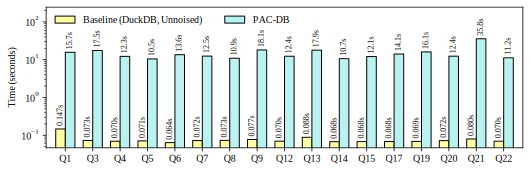

In [80]:
# Load data
df = pl.read_json("benchmarks/merged.json")
unnoised = pl.read_json("unnoised/times.json").filter(pl.col("query").is_in(df["query"].implode()))

queries = df["query"].to_list()
step_columns = ["step1", "step2", "step3"]
step_values = [df[col].to_list() for col in step_columns]
noised_total = df.with_columns(
    (pl.col("step1") + pl.col("step2") + pl.col("step3")).alias("total")
)["total"].to_list()
unnoised_total = unnoised["total"].to_list()

relative_speed_labels = [f"{v:.1f}x" for v in df2['relative_speed'].to_list()]

# Plot setup
x = range(len(queries))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(7.5, 2.5))
bottom = [0] * len(queries)

# Plot unnoised system (left bar in each group)
b1 = plt.bar(
    [i - bar_width / 2 for i in x],
    unnoised_total,
    width=bar_width,
    label='Baseline (DuckDB, Unnoised)',
    color=colors[4],
    edgecolor='k'
)

b2 = plt.bar(
    [i + bar_width / 2 for i in x],
    noised_total,
    width=bar_width,
    label='PAC-DB',
    color=colors[5],
    edgecolor='k'
)

# Plot component system (right stacked bar in each group)
# step_labels = ["1. Run DuckDB Query over Samples", "2. Compute PAC Noise", "3. Reconstruct Table"]
# for values, label, style in zip(step_values, step_labels, [bar1, bar2, bar3]):
#     plt.bar(
#         [i + bar_width / 2 for i in x],
#         values,
#         bottom=bottom,
#         width=bar_width,
#         label=label,
#         **style
#     )
#     bottom = [b + v for b, v in zip(bottom, values)]

# Final touches
plt.yscale('log')

ax.bar_label(b2, [f"{v:.1f}s" for v in noised_total], label_type='edge', padding=3, fontsize=8, color='black', rotation=90)
ax.bar_label(b1, [f"{v:.3f}s" for v in unnoised_total], label_type='edge', padding=3, fontsize=8, color='black', rotation=90)

plt.xticks(x, queries, ha='center')
plt.xlim([x[0] - (2*bar_width), x[-1] + (2*bar_width)])

plt.ylim(plt.ylim()[0], plt.ylim()[1] * 5)  # Add some space above the bars
plt.ylabel('Time (seconds)')

plt.legend(loc='upper left', ncols=2)
plt.tight_layout()
plt.show()
